In [1]:
import os
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
 
# Define custom dataset
class DefectDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.file_paths = []
        self.labels = []

        for label, defect_class in enumerate(self.classes):
            defect_dir = os.path.join(root_dir, defect_class)

            for img_file in os.listdir(defect_dir):
                self.file_paths.append(os.path.join(defect_dir, img_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
 
# Load the dataset
data_dir = "data/training_sessions/BEOL_CMP_new_trng/images"

transform = transforms.Compose([
    transforms.Resize((960, 1440)),
    transforms.ToTensor()
])

dataset = DefectDataset(data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)
 
# Define the model
class DefectClassifier(nn.Module):
    def __init__(self, pretrained_model):
        super(DefectClassifier, self).__init__()

        self.branch1 = nn.Sequential(
            pretrained_model,
            nn.Linear(1000, 2)
        )

        self.branch2 = nn.Sequential(
            pretrained_model,
            nn.Linear(1000, 23)
        )

    def forward(self, x):
        def resize_segment(segment):
            return F.interpolate(segment, size=(224, 224), mode='bilinear', align_corners=False)

        _, _, height, width = x.shape

        if height == 960 and width == 1440:
            first_4_segments = resize_segment(x[:, :, :960, :960])
            last_2_segments = resize_segment(x[:, :, :960, 960:1440])
            out1 = self.branch1(first_4_segments)
            out2 = self.branch2(last_2_segments)
            return out1, out2

        else:
            raise ValueError(f"Unexpected image dimensions: {height}x{width}")
 
# Load pretrained model and weights
pretrained_model = timm.create_model('convit_base', pretrained=False, num_classes=1000)
state_dict = torch.load('./convit_base.fb_in1k/pytorch_model.bin', map_location='cpu')
pretrained_model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DefectClassifier(pretrained_model).to(device)
model.load_state_dict(torch.load("model_new.pth", map_location=device))
model.eval()

DefectClassifier(
  (branch1): Sequential(
    (0): ConViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): GPSA(
            (qk): Linear(in_features=768, out_features=1536, bias=False)
            (v): Linear(in_features=768, out_features=768, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (pos_proj): Linear(in_features=3, out_features=16, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=

Generating confusion matrix...


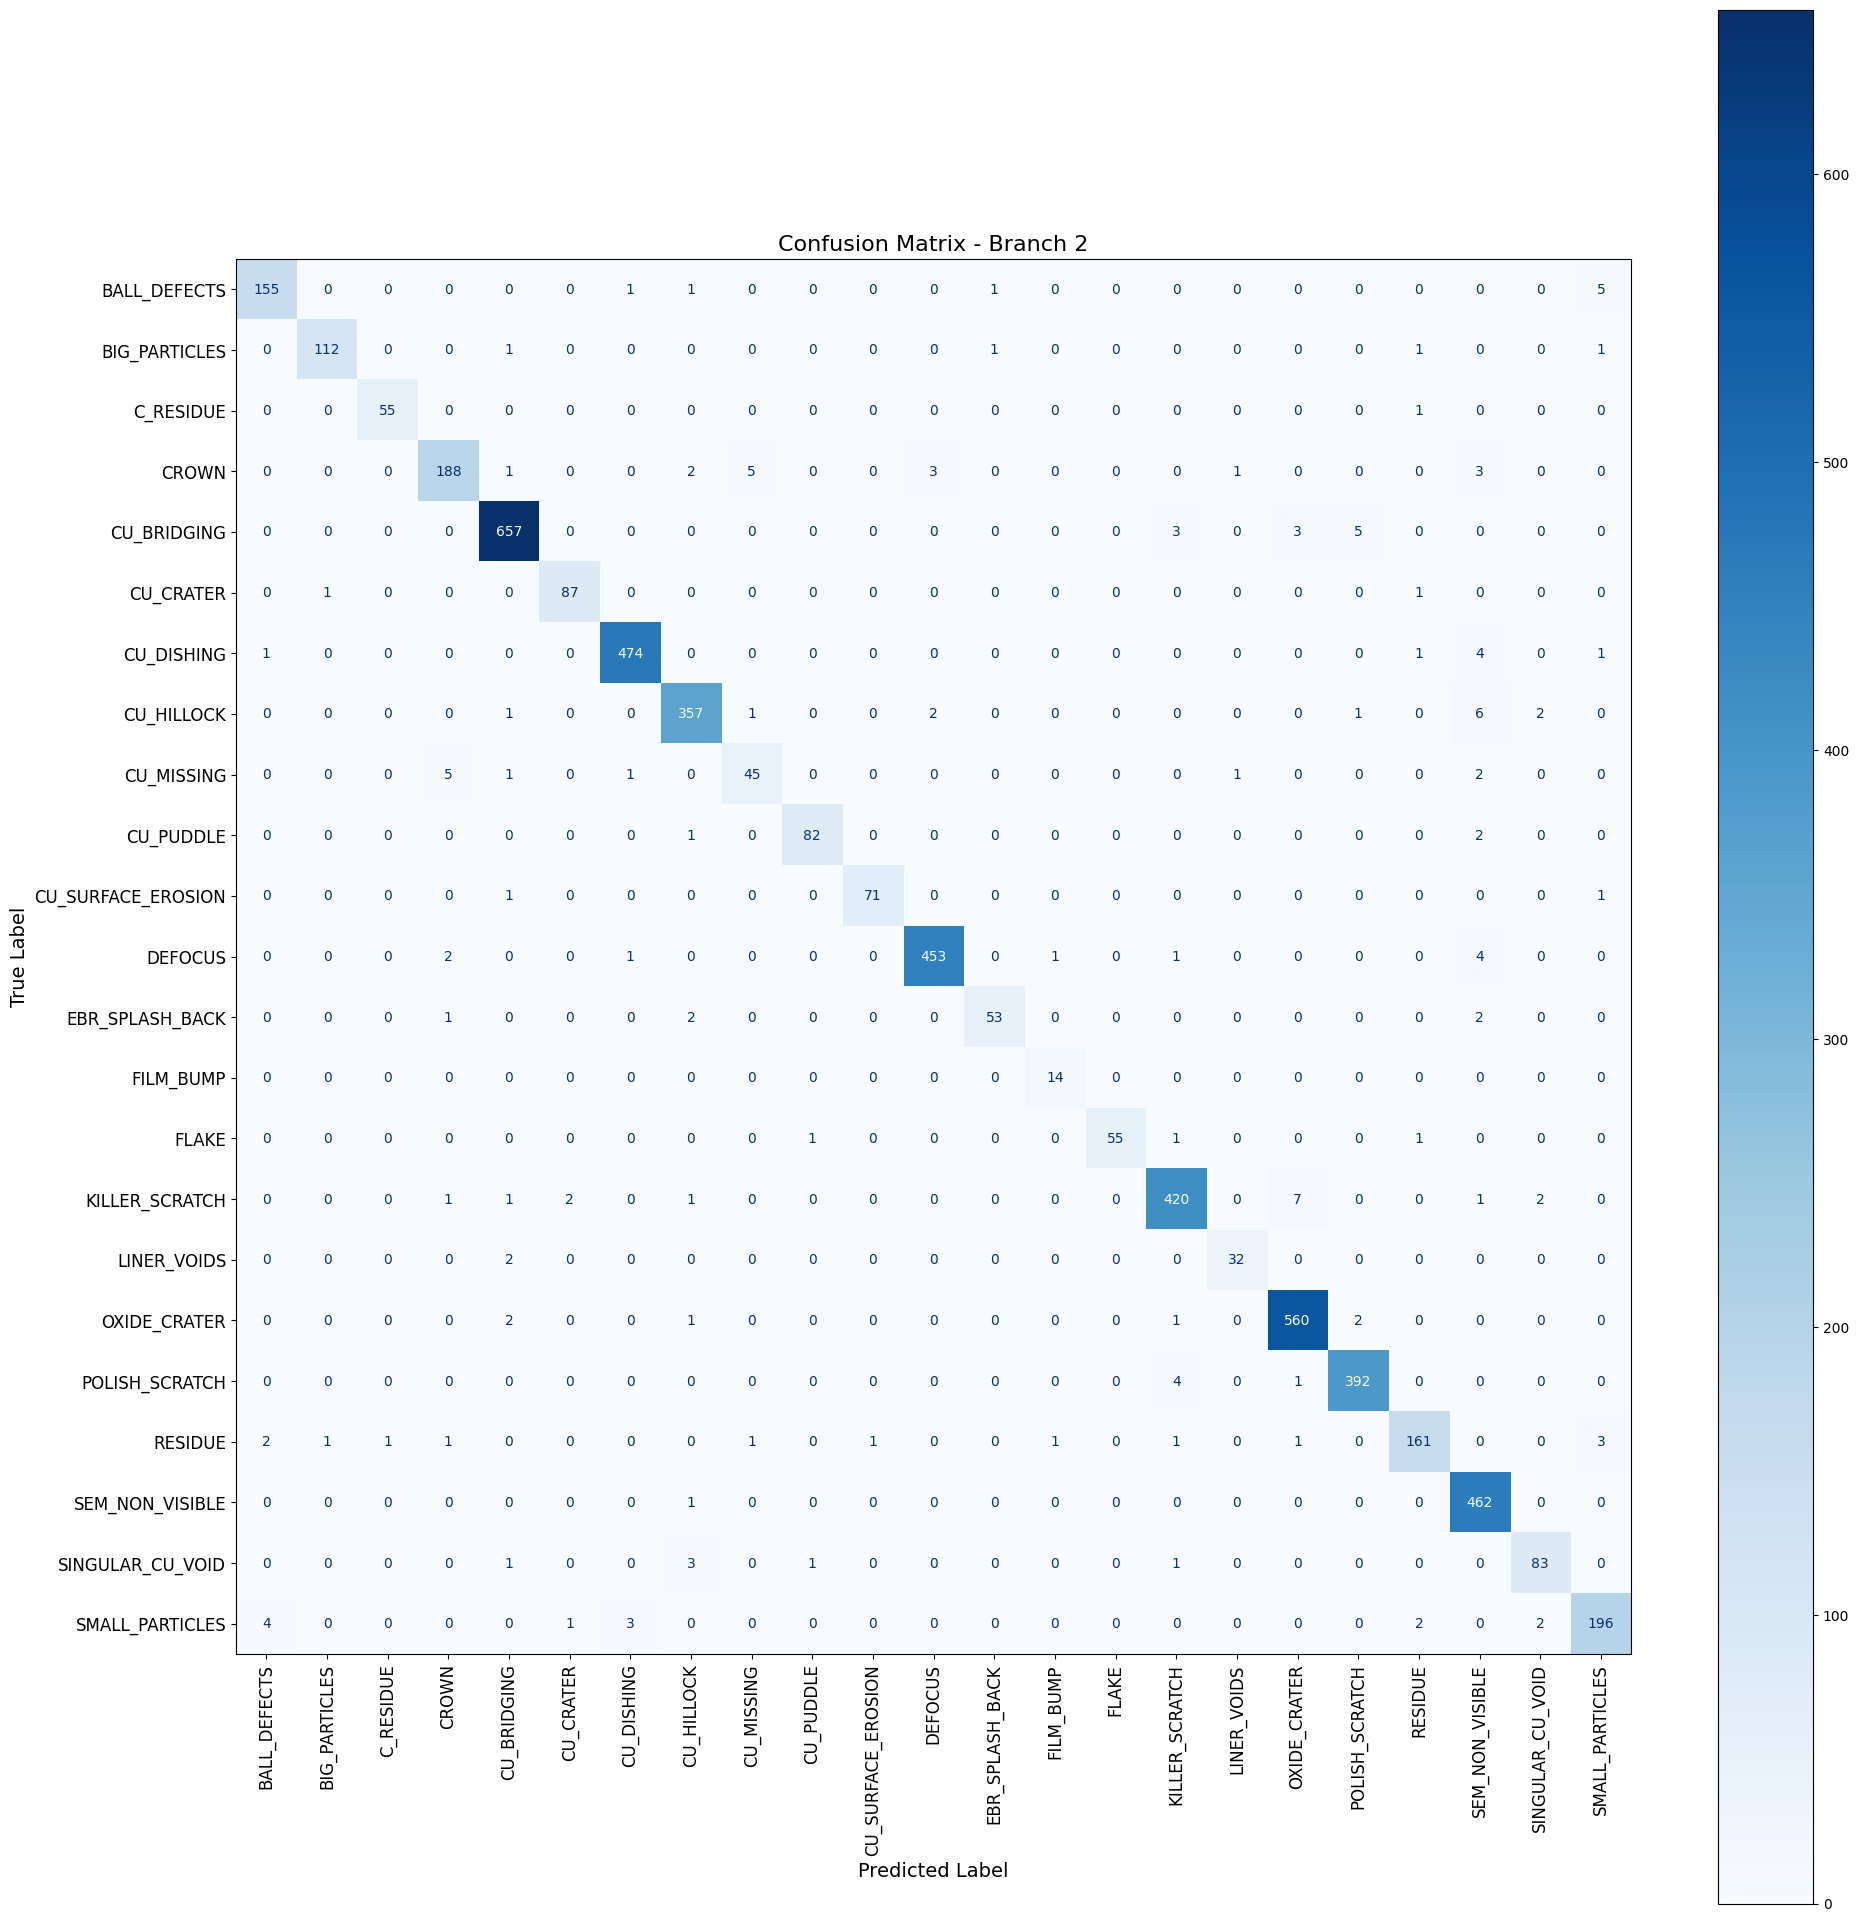

In [2]:
# Custom labels in the specified order
label_to_name = {
    0: "BALL_DEFECTS",
    1: "BIG_PARTICLES",
    2: "C_RESIDUE",
    3: "CROWN",
    4: "CU_BRIDGING",
    5: "CU_CRATER",
    6: "CU_DISHING",
    7: "CU_HILLOCK",
    8: "CU_MISSING",
    9: "CU_PUDDLE",
    10: "CU_SURFACE_EROSION",
    11: "DEFOCUS",
    12: "EBR_SPLASH_BACK",
    13: "FILM_BUMP",
    14: "FLAKE",
    15: "KILLER_SCRATCH",
    16: "LINER_VOIDS",
    17: "OXIDE_CRATER",
    18: "POLISH_SCRATCH",
    19: "RESIDUE",
    20: "SEM_NON_VISIBLE",
    21: "SINGULAR_CU_VOID",
    22: "SMALL_PARTICLES",
}
 
# Generate predictions and true labels
true_labels = []
branch2_preds = []
 
with torch.no_grad():
    for images, labels in data_loader:
        # Move the images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)
        out1, out2 = model(images)
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for storing
        branch2_preds.extend(torch.argmax(out2, axis=1).cpu().numpy())  # Move preds back to CPU
 
print("Generating confusion matrix...")
 
# Confusion Matrix for Branch 2
cm_branch2 = confusion_matrix(true_labels, branch2_preds)
 
# Rearrange labels to match custom order
ordered_labels = [label_to_name[i] for i in range(len(label_to_name))]
 
# Plot the confusion matrix
plt.figure(figsize=(20, 20))  # Increase figure size
disp_branch2 = ConfusionMatrixDisplay(confusion_matrix=cm_branch2, display_labels=ordered_labels)
disp_branch2.plot(cmap="Blues", values_format="d", ax=plt.gca())
 
# Rotate x-axis labels to vertical
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix - Branch 2", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_branch2.png", bbox_inches="tight", dpi=300)
plt.show()

In [7]:
output_folder = "Heatmaps"
os.makedirs(output_folder, exist_ok=True)  # Ensure the folder exists
 
def plot_heatmap(image, true_label, pred_label, title, image_index):
    heatmap = image.mean(dim=0).cpu().numpy()  # Example visualization
 
    # Convert true_label and pred_label to integers for dictionary lookup
    true_label = int(true_label)
    pred_label = int(pred_label)
    sns.heatmap(heatmap, cmap="viridis", cbar=False)
    plt.title(f"{title} - True: {label_to_name[true_label]}, Pred: {label_to_name[pred_label]}")
    plt.axis("off")
 
    # Save the heatmap
    save_path = os.path.join(output_folder, f"misclassified_{image_index + 1}.png")
    plt.savefig(save_path, bbox_inches="tight")
    plt.close()
 
misclassified_count = 0  # To track the number of misclassified images
image_index = 0  # Counter for misclassified images
 
with torch.no_grad():
    for idx, (images, labels) in enumerate(data_loader):
        # Move the images and labels to the same device as the model
        images = images.to(device)
        labels = labels.to(device)
        out1, out2 = model(images)
        pred2 = torch.argmax(out2, axis=1)
 
        for i in range(images.size(0)):
            if pred2[i] != labels[i]:
                plot_heatmap(images[i], labels[i], pred2[i], "Misclassified Image", image_index)
                misclassified_count += 1
                image_index += 1  # Increment the image index
 
                if misclassified_count >= 5:  # Limit to 5 heatmaps
                    break

        if misclassified_count >= 5:  # Stop outer loop once 5 heatmaps are shown
            break